<a href="https://colab.research.google.com/github/AlbertoZerbinati/nlp-depparsing/blob/main/dependency_parsing_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Dependency Parsing Project
Alberto Zerbinati, Flavia Gianfrate

## Introduction

This project is about implementing a trainsition-based dependency parsing system.
We use the **arc-eager** model, augmenting the parser with neural machinery for contextual word embeddings and for choosing the most appropriate parser actions.

We compare the following features for representing tokens:
* BiLSTM embeddings
* BERT embeddings

We adopt an MLP for next transition classification, based on top-most stack token and first token in the buffer.

We disregard arc labels in dependency trees.

In [1]:
!pip install datasets    # huggingface library with dataset
!pip install conllu      # aux library for processing CoNLL-U format
!pip install tensorboard # for training logs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# for neural models
import torch
import torch.nn as nn
import numpy as np
from functools import partial
from torch.utils.tensorboard import SummaryWriter

# for dataset exploration and processing
from datasets import load_dataset
import spacy
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict, Counter
import string

# other
from enum import IntEnum
from typing import List
import locale

locale.getpreferredencoding = lambda: "UTF-8"

## Arc-eager parser

A **configuration** of the arc-eager parser is a triple of the form $( \sigma, \beta, A)$
where:

* $\sigma$ is the stack;
* $\beta$ is the input buffer;
* $A$ is a set of arcs constructed so far.

We write $\sigma_i$, $i \geq 1$, for the $i$-th token in the stack; we also write $\beta_i$, $i \geq 1$, for the $i$-th token in the buffer.

The parser can perform four types of **actions** (transitions):

* **left-arc**, which pops the top-most stack element and attaches it as a
dependent of the first buffer element;
* **right-arc**, which attaches the first buffer element as a dependent of the
top-most stack element, and shifts the first buffer element into the
stack;
* **reduce**, which pops the stack;
* **shift**, which removes the first element from the buffer and pushes it into the stack.

Let $w = w_0 w_1 \cdots w_{n}$ be the input sentence, with $w_0$ the special symbol `<ROOT>`.
Stack and buffer are implemented as lists of integers, where `j` represents word $w_j$.  Top-most stack token is at the right-end of the list; first buffer token is at the left-end of the list.
Set $A$ is implemented as an array `arcs` of size $n+1$ such that if arc $(w_i \rightarrow w_j)$ is in $A$ then `arcs[j]=i`, and if $w_j$ is still missing its head node in the tree under construction, then `arcs[j]=-1`. We always have `arcs[0]=-1`.  We use this representation also for complete dependency trees.


In [3]:
class Move(IntEnum):
  LEFT_ARC = 0
  RIGHT_ARC = 1
  REDUCE = 2
  SHIFT = 3

In [4]:
class ArcEagerParser:
  def __init__(self, sentence: List[str], verbose: bool = False):
    self.verbose = verbose
    self.sentence = sentence

    # configuration
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # two shift moves to initialize the stack
    self.__shift()
    self.__shift()

  def __left_arc(self) -> bool:
    # preconditions
    o1 = self.stack[-1]
    if o1 == 0 or self.arcs[o1] != -1:
      if self.verbose:
        print("LEFT ARC not done")
      return False

    self.stack.pop()
    b1 = self.buffer[0]
    self.arcs[o1] = b1

    if self.verbose:
      print("LEFT ARC done")

    return True

  def __right_arc(self) -> bool:
    o1 = self.stack[-1]
    b1 = self.buffer[0]
    self.arcs[b1] = o1

    self.buffer = self.buffer[1:]
    self.stack.append(b1)

    if self.verbose:
      print("RIGHT ARC done")

    return True

  def __reduce(self) -> bool:
    # preconditions
    o1 = self.stack[-1]
    if self.arcs[o1] == -1:
      if self.verbose:
        print("REDUCE not done")
      return False

    self.stack.pop()

    if self.verbose:
      print("REDUCE done")

    return True

  def __shift(self) -> bool:
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

    if self.verbose:
      print("SHIFT done")

    return True

  def perform_move(self, move: Move) -> bool:
    '''
    performs the requested move.
    returns True if the move was performed, False otherwise (preconditions not met).
    '''
    if move == Move.LEFT_ARC:
      return self.__left_arc()
    elif move == Move.RIGHT_ARC:
      return self.__right_arc()
    elif move == Move.REDUCE:
      return self.__reduce()
    elif move == Move.SHIFT:
      return self.__shift()

  def is_tree_final(self):
    return len(self.buffer) == 0 # sufficient (no need to look at the stack)

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

We now do a few manual tests on the parser.  Consider the sentence `He began to write again .` and the associated dependency tree
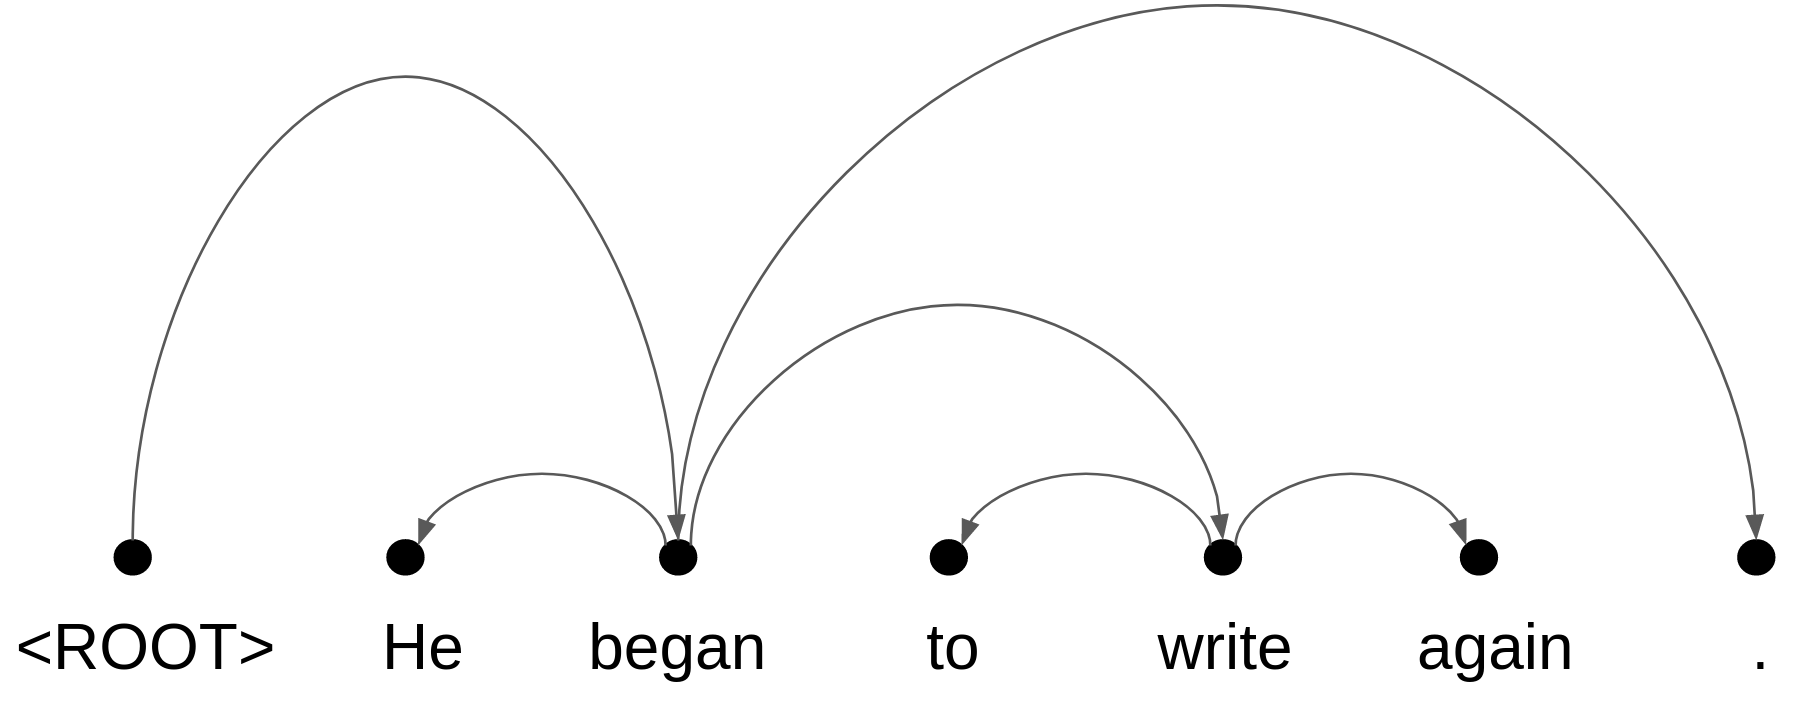

In [5]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEagerParser(sentence, verbose=True)
parser.print_configuration()

SHIFT done
SHIFT done
['<ROOT>', 'He'] ['began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [6]:
parser.perform_move(Move.LEFT_ARC)

parser.print_configuration()

LEFT ARC done
['<ROOT>'] ['began', 'to', 'write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]


In [7]:
parser.perform_move(Move.SHIFT)

parser.print_configuration()

SHIFT done
['<ROOT>', 'began'] ['to', 'write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]


In [8]:
parser.perform_move(Move.RIGHT_ARC)

parser.print_configuration()

RIGHT ARC done
['<ROOT>', 'began', 'to'] ['write', 'again', '.']
[-1, 2, -1, 2, -1, -1, -1]


In [9]:
parser.perform_move(Move.REDUCE)

parser.print_configuration()

REDUCE done
['<ROOT>', 'began'] ['write', 'again', '.']
[-1, 2, -1, 2, -1, -1, -1]


If we perform an **illegal move**, the parser won't do it.
For instance, a precondition for the REDUCE operation is that the popped token has a head already. If it's not met, then the operation won't occur.

In [10]:
parser.perform_move(Move.REDUCE)

parser.print_configuration()

REDUCE not done
['<ROOT>', 'began'] ['write', 'again', '.']
[-1, 2, -1, 2, -1, -1, -1]


## Oracle

Implementation of the arc-eager oracle. Given a parser configuration and the gold tree, it is able to return the next gold move (`get_next_gold_move` method).

In [11]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def __is_left_arc_gold(self) -> bool:
    if len(self.parser.buffer) <= 0 or len(self.parser.stack) <= 0:
      return False

    o1 = self.parser.stack[-1]
    b1 = self.parser.buffer[0]

    if o1 == 0:
      return False

    if self.gold[o1] == b1:
      return True

    return False

  def __is_right_arc_gold(self) -> bool:
    if len(self.parser.buffer) <= 0 or len(self.parser.stack) <= 0:
      return False

    o1 = self.parser.stack[-1]
    b1 = self.parser.buffer[0]

    if self.gold[b1] == o1:
      return True

    return False

  def __is_reduce_gold(self) -> bool:
      if len(self.parser.buffer) <= 0 or len(self.parser.stack) <= 0:
        return False

      o1 = self.parser.stack[-1]
      b1 = self.parser.buffer[0]

      # check that we can pop
      if o1 == 0:
          return False
      if self.parser.arcs[o1] == -1:
          return False

      # loop through all the stack (k < i) and check for arcs with the o1 or b1
      # in case one is found, the reduction can occur
      for i in range(1, len(self.parser.stack)):
          o2 = self.parser.stack[-i - 1]

          if self.gold[b1] == o2 or self.gold[o2] == b1:
              return True

      return False

  def get_next_gold_move(self) -> Move:
    if self.__is_left_arc_gold():
      return Move.LEFT_ARC
    elif self.__is_right_arc_gold():
      return Move.RIGHT_ARC
    elif self.__is_reduce_gold():
      return Move.REDUCE
    else:
      return Move.SHIFT

Let us come back to our example.

In [12]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEagerParser(sentence, verbose=True)
oracle = Oracle(parser, gold)

parser.print_configuration()

SHIFT done
SHIFT done
['<ROOT>', 'He'] ['began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


We do a simple manual test on the oracle

In [13]:
print("get_next_gold_move:", oracle.get_next_gold_move())
print()
parser.perform_move(Move.LEFT_ARC)
print()
parser.print_configuration()

get_next_gold_move: Move.LEFT_ARC

LEFT ARC done

['<ROOT>'] ['began', 'to', 'write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]


Then we let the oracle run and we test that it produces the correct gold tree

In [14]:
parser.print_configuration()

while not parser.is_tree_final():
  print()
  move = oracle.get_next_gold_move()
  parser.perform_move(move)
  print()
  parser.print_configuration()

print()
print("gold:", gold)

['<ROOT>'] ['began', 'to', 'write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]

RIGHT ARC done

['<ROOT>', 'began'] ['to', 'write', 'again', '.']
[-1, 2, 0, -1, -1, -1, -1]

SHIFT done

['<ROOT>', 'began', 'to'] ['write', 'again', '.']
[-1, 2, 0, -1, -1, -1, -1]

LEFT ARC done

['<ROOT>', 'began'] ['write', 'again', '.']
[-1, 2, 0, 4, -1, -1, -1]

RIGHT ARC done

['<ROOT>', 'began', 'write'] ['again', '.']
[-1, 2, 0, 4, 2, -1, -1]

RIGHT ARC done

['<ROOT>', 'began', 'write', 'again'] ['.']
[-1, 2, 0, 4, 2, 4, -1]

REDUCE done

['<ROOT>', 'began', 'write'] ['.']
[-1, 2, 0, 4, 2, 4, -1]

REDUCE done

['<ROOT>', 'began'] ['.']
[-1, 2, 0, 4, 2, 4, -1]

RIGHT ARC done

['<ROOT>', 'began', '.'] []
[-1, 2, 0, 4, 2, 4, 2]

gold: [-1, 2, 0, 4, 2, 4, 2]


## Dataset

We use the huggingface [datasets](https://github.com/huggingface/datasets) library, and train on the English [treebank](https://huggingface.co/datasets/viewer/?dataset=universal_dependencies) from the Universal Dependency project, in particular we use the subset "en_gum".\
GUM, the Georgetown University Multilayer corpus, is an open source multilayer corpus of richly annotated texts from multiple text types. The corpus is collected and expanded as part of the curriculum in the course LING-367 "Computational Corpus Linguistics" at Georgetown University by students which each year choose a text from within one of four possible genres. The selection of text types is meant to represent different communicative purposes, while coming from sources that are readily and openly available, so that new texts can be annotated and published with ease.

Variable `full_ds` contains train, test and validation set.
Each set consists of a dictionary and has the following features: 'idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'. However, only some of these are useful for our task.\
Variable `dataset` below is an array recording the training set.


In [15]:
full_ds = load_dataset('universal_dependencies', 'en_gum')

  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
dataset = full_ds['train']

In [17]:
# info about dataset
print("dataset's lenght:", len(dataset))
print("dataset's keys:", dataset[0].keys(), end="\n\n")

np.random.seed(42)
rnd_ints = np.random.randint(len(dataset), size = 3)

print("three random samples:")
# we look into some instances in the dataset and print their tokens and (gold) dependency tree
for i in rnd_ints:
  print("tokens:", dataset[i.item()]["tokens"])
  print("heads :", dataset[i.item()]["head"], end="\n\n")

dataset's lenght: 4287
dataset's keys: dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])

three random samples:
tokens: ['During', 'this', 'period', ',', 'he', 'seems', 'to', 'have', 'found', 'time', 'for', 'studying', 'and', 'writing', '.']
heads : ['3', '3', '6', '3', '6', '0', '9', '9', '6', '9', '12', '10', '14', '12', '6']

tokens: ['Hours', 'of', 'stress', ',', 'or', 'regular', 'exposure', 'to', 'stressful', 'situations', ',', 'can', 'cause', 'serious', 'health', 'problems', '.']
heads : ['13', '3', '1', '7', '7', '7', '1', '10', '10', '7', '1', '13', '0', '16', '16', '13', '13']

tokens: ['Chatham', 'Motors', 'have', 'a', 'range', 'of', 'nice', 'rental', 'vans', 'available', 'as', 'well', 'and', 'they', 'provide', 'pretty', 'good', 'service', 'for', 'both', 'visitors', 'and', 'locals', '.']
heads : ['2', '3', '0', '5', '3', '9', '9', '9', '5', '9', '12', '10', '15', '15', '3', '17', '18', '15', '21', '21', '18', '23', '21',

**Important**: the key `head` selects an array representing the gold dependency tree for the sentence at hand, in the format discussed above.  However, the integers in this array are represented as strings and need to be **converted** into integers.  We will have to do this conversion at several places below.

In [18]:
train_df = full_ds['train'].to_pandas()
test_df = full_ds['test'].to_pandas()
validation_df = full_ds['validation'].to_pandas()

In [19]:
full_ds_pd = pd.concat([train_df, test_df, validation_df], ignore_index=True)
tokens = full_ds_pd['tokens']

### Data exploration

Before starting with the construction of the models, it is good to analyze the data on which we will train and evaluate them.

#### Tokens and sentences analy
We can start by exploring some fundamental characteristics of text data, such as the distribution of sentence length and the distribution of average token lenght per sentece.

In [20]:
def number_of_sentences(tokens):
  return len(tokens)

def number_of_types(tokens):
  return len(set([token for sample in tokens for token in sample]))

def number_of_tokens(tokens):
  return len([token for sample in tokens for token in sample])

def sentence_len(tokens):
  sentence_len = [len(sent) for sent in tokens]
  full_ds_pd['number of tokens'] = sentence_len

  fig, ax = plt.subplots()
  ax.set(xlim=(0,100))
  ax.set(xticks=np.arange(100, step=10))
  ax.set(title="Sentence length distribution")
  sns.histplot(data=full_ds_pd, x='number of tokens', kde=True, discrete=True, ax=ax, color='green')

def avg_token_len(tokens):
  token_len = tokens.apply(lambda x : np.mean([len(i) for i in x]))
  full_ds_pd['token length'] = token_len

  fig, ax = plt.subplots()
  ax.set(xlim=(0,10))
  ax.set(xticks=np.arange(10))
  ax.set(title="Average token length per sentence distribution")
  sns.histplot(data=full_ds_pd, x="token length", kde=True, ax=ax, color='green')

In [21]:
print(f"The full dataset is made of {number_of_sentences(tokens)} sentences.")
print(f"It contains {number_of_types(tokens)} types and {number_of_tokens(tokens)} tokens.")

The full dataset is made of 5961 sentences.
It contains 15284 types and 113385 tokens.


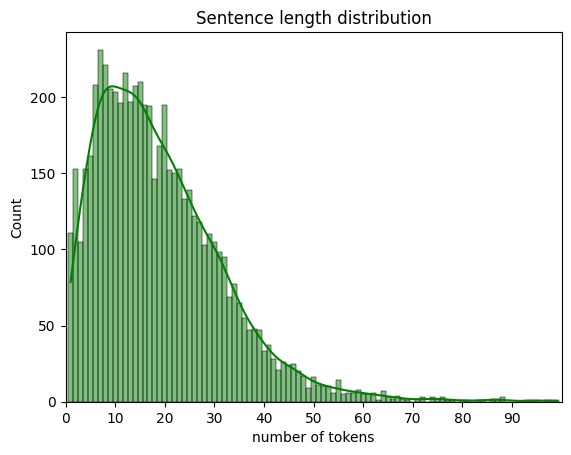

In [22]:
sentence_len(tokens)

The histogram shows that the number of tokens in the sentences varies quite a lot, in the range [1; 90].

The above distribution also shows that most sentences are within 30 tokens, and longer sentences get more and more rare.

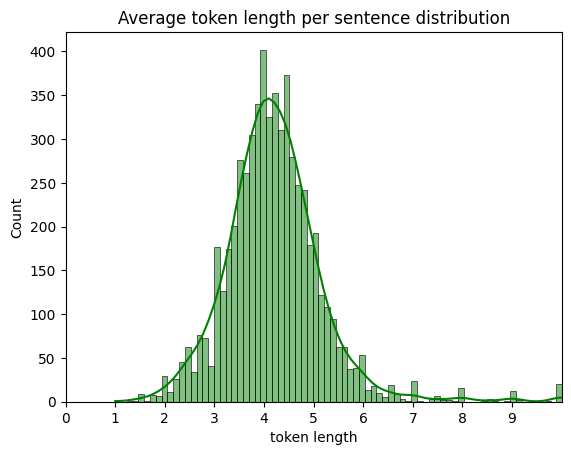

In [23]:
avg_token_len(tokens)

The average token length concentrates around 4.

We should consider that this result is certainly lowered by the presence of punctuation marks that have length one, and by stopwords that usually consist of a few characters.

#### Most frequent words and entities

At this point there are at least two reasons to extract and analyze the stopwords in the dataset.

The first is to understand their impact on the average token length, and the second is to ignore them when we analyze the dataset semantics.

So let's try to see what the most common stop-words are and to what extent they occur in the dataset.
We then proceed remove punctuation marks and stop-words from the dataset (after applying a lower folding) to look at which are the most frequent words and entities.

In [24]:
tokens_list = tokens.values.tolist()
corpus = [word.lower() for i in tokens_list for word in i]

nlp = spacy.load("en_core_web_sm")
stop = nlp.Defaults.stop_words
string.punctuation = string.punctuation + '“' + '”' + '—'

In [25]:
# generate sorted dicts associating tokens to their frequencies
all_tokens_freq_dict = defaultdict(int)
stopwords_freq_dict = defaultdict(int)
tokens_freq_dict = defaultdict(int)
for token in corpus:
  if token in stop or token in string.punctuation:
    stopwords_freq_dict[token]+=1
  else:
    tokens_freq_dict[token]+=1
  all_tokens_freq_dict[token]+=1

stopwords_freq_dict_sorted = {k: v for k, v in sorted(stopwords_freq_dict.items(), key=lambda item: item[1], reverse=True)}
tokens_freq_dict_sorted = {k: v for k, v in sorted(tokens_freq_dict.items(), key=lambda item: item[1], reverse=True)}
all_tokens_freq_dict_sorted = {k: v for k, v in sorted(all_tokens_freq_dict.items(), key=lambda item: item[1], reverse=True)}

In [26]:
def stopwords_hist():
  keys = list(stopwords_freq_dict_sorted.keys())
  values = list(stopwords_freq_dict_sorted.values())

  fig, ax = plt.subplots()
  ax.set(title="Stop words and punctuation frequency")
  sns.barplot(x=values[:10], y=keys[:10], ax=ax, palette="flare")

def non_stopwords_hist():
  keys = list(tokens_freq_dict_sorted.keys())
  values = list(tokens_freq_dict_sorted.values())

  fig, ax = plt.subplots()
  ax.set(title="Other tokens frequency")
  sns.barplot(x=values[:10], y=keys[:10], ax=ax, palette="flare")

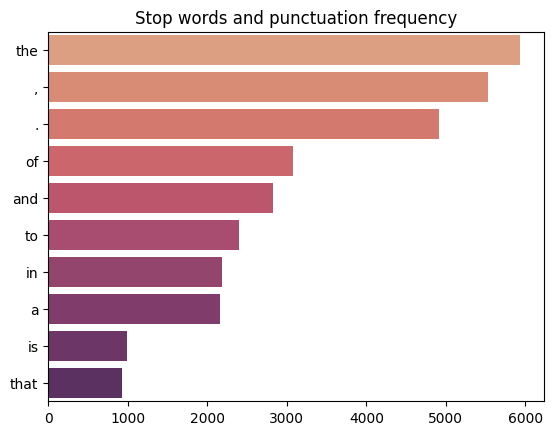

In [27]:
stopwords_hist()

We can see that stopwords such as “the”, "of" and "and" are quite frequent, and so are the "." and "," punctuations.

In particular we can notice that the article "the" occurs almost 6000 times. This had an impact in the average token length analysis above.

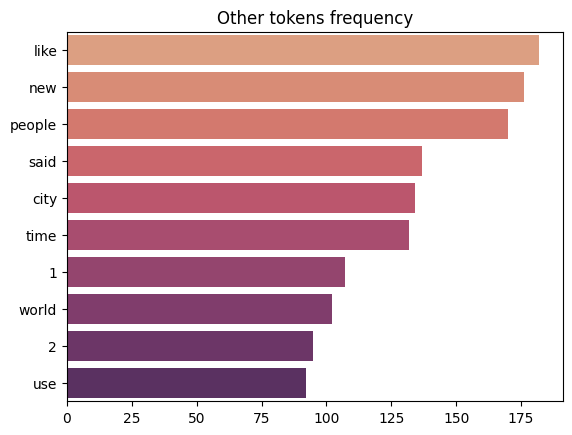

In [28]:
non_stopwords_hist()

After removing stopwords and punctuation, from this histogram we can observe that the most frequent words are "like", "new" and "people", which occur more than 150 times.

Their frequency is much lower than that of the stopwords we see above.
Let's see how they rank overall.


In [29]:
# let's see how the most frequent tokens rank with respect to all tokens (stopwords included)
keys = list(all_tokens_freq_dict_sorted.keys())

print(f'"like" is the {keys.index("like")}th most frequent token.')
print(f'"new" is the {keys.index("new")}th most frequent token.')
print(f'"people" is the {keys.index("people")}th most frequent token.')

"like" is the 66th most frequent token.
"new" is the 69th most frequent token.
"people" is the 72th most frequent token.


Named entity recognition is an information extraction method in which entities that are present in the text are classified into predefined entity types like “Person”,” Place”,” Organization”, etc. By using NER we can get great insights about the types of entities present in the given text dataset.\
In the presence of a dataset that contains texts of a different nature, this method can help to understand points in common between the various sentences, observing which entities are the most common and to what extent.

Let's see an example for a single sentence of our dataset:

In [30]:
# example
print(full_ds_pd.iloc[0,1])
doc=nlp(full_ds_pd.iloc[0,1])

[(x.text, x.label_) for x in doc.ents]

Aesthetic Appreciation and Spanish Art:


[('Aesthetic Appreciation', 'ORG'), ('Spanish', 'NORP')]

In [31]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

def entity_recognition(text):
  ent = text.apply(lambda x : ner(x))
  ent = [x for sub in ent for x in sub]
  counter3 = Counter(ent)
  count3 = counter3.most_common()
  fig, ax = plt.subplots()
  ax.set(xlim=(0,1800))
  ax.set(xticks=np.arange(1800, step=300))
  ax.set(title="Entity recognition")
  x, y = map(list,zip(*count3))
  sns.barplot(x=y, y=x, ax=ax)

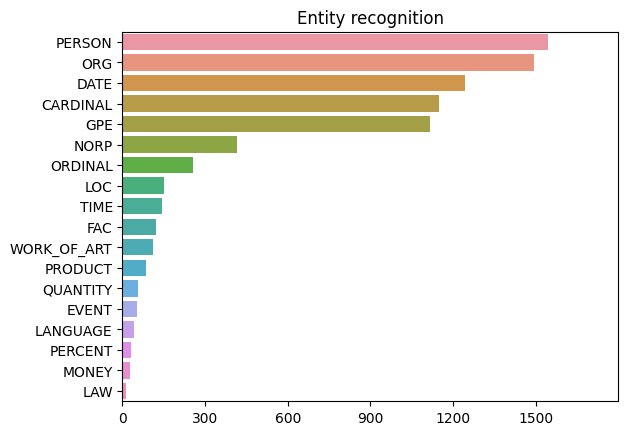

In [32]:
entity_recognition(full_ds_pd['text'])

From the plot we observe that personal names are very common in our dataset, immediately followed by ORG which includes information such as companies, political groups, musical bands, sport clubs, government bodies, and public organizations. These entities show up around 1500 times.

## Create training data and iterable dataloaders



Recall that to run the arc-eager parser we need a **classifier** that looks at some of the content of the current parser configuration and selects an approapriate action.  In order to train the classifier, we need to convert the gold trees in our treebank into several pairs of the form configuration/gold action.  This is what we do in this section.

First of all, we need to preprocess the training set. We remove non-projective trees.  We also create a dictionary of word/index pairs, to be used later when creating word embeddings.  Words that have less than three occurrences are not encoded and will later be mapped to special token `<unk>`.

In [33]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [34]:
train_dataset = load_dataset('universal_dependencies', 'en_gum', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_gum', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_gum', split="test")

# remove non-projective sentences from the dataset (the oracle doesn't work for them):
# heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample["head"]])]
# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Number of samples:
Train:	 4055
Dev:	 784
Test:	 890


The next function is used to process our data and create the actual training samples.

For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree.  We then pair configurations and canonical actions.  Since our neural classifier will look only into $\sigma_1$, $\sigma_2$ and $\beta_1$, we do not have to record the full parser configuration.

In [35]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce, 3 shift

  if get_gold_path:  # only for training
    parser = ArcEagerParser(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration (top-most stack element + first buffer element)
      configuration = [parser.stack[-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      gold_move = oracle.get_next_gold_move()
      gold_moves.append(gold_move)
      parser.perform_move(gold_move)

  return enc_sentence, gold_path, gold_moves, gold

Next function used to batch the training data.

In [36]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

Finally, we create dataloaders for train, development and test sets.

In [37]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

## Create baseline neural network model (Bi-LSTM)

We are now ready to train our parser on the dataset. We start with the definition of some parameters.


In [38]:
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2
EPOCHS = 15
LR = 0.001   # learning rate

Next, we create our model. It consists of a Bi-LSTM to represent words together with their contexts and a feedforward network to predict the next move of the parser.

In [39]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(4*LSTM_SIZE, MLP_SIZE, bias=True) # the input size is 2*size_configuration*LSTM_SIZE
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)

  # forward method at training time
  # uses bi-lstm to extract features from the input sentences in x
  # uses mlp to classify the next move
  # paths, for each sentence in x, gives the list of configurations it goes
  # through in the gold parsing
  # we are parellelizing everything over various sentences (in a batch)/parsers
  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    # return the predicted move
    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    # print(h.size())
    # QUESTION: I understand h is the contextualized representation of the
    # batch senteces, but what is the size?
    # ANSWER: size h: (sentence_length, batch_size, output_hidden_units)
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # forward method at inferece time
  # We run the parser and at each step we pick as next move the one with the
  # highest score assigned by the model
  # the parser is used to keep track of how much of the sentences (x) were
  # parsed so far. each parser works on a single sentence (again "in parallel")
  def infere(self, x):

    parsers = [ArcEagerParser(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency trees (one for each sentence/parser)
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores
  # obtained (in parallel for each parser).
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        was_move_performed = False
        sorted_moves = [Move(m.item()) for m in torch.argsort(moves[i], descending=True)]

        for move in sorted_moves:
          if was_move_performed:
            break
          was_move_performed = parsers[i].perform_move(move)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

print()
print("Model")
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f'Layer: {name} \t Size: {param.shape}')
print()

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Model
Layer: embeddings.weight 	 Size: torch.Size([3443, 200])
Layer: lstm.weight_ih_l0 	 Size: torch.Size([800, 200])
Layer: lstm.weight_hh_l0 	 Size: torch.Size([800, 200])
Layer: lstm.weight_ih_l0_reverse 	 Size: torch.Size([800, 200])
Layer: lstm.weight_hh_l0_reverse 	 Size: torch.Size([800, 200])
Layer: w1.weight 	 Size: torch.Size([200, 800])
Layer: w2.weight 	 Size: torch.Size([4, 200])



##Train and Test
Now that we have defined all our components, we are ready to train and test our model.

First we define our evaluation function. We use UAS (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [41]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

Next, we define our train loop and the test function to run inference.

In [42]:
def train(model, dataloader, criterion, optimizer, writer: SummaryWriter, epoch_index: int):
  model.train()
  total_loss = 0
  batch_loss = 0
  count = 0

  # variables used to log K times the loss for each batch
  K = 5
  num_batches = len(dataloader)
  n = int(num_batches / K)

  for i, batch in enumerate(dataloader):
    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()
    batch_loss += loss.item()

    loss.backward()
    optimizer.step()

    if i % n == n-1:
      last_loss = batch_loss / n # avg loss per batch
      print("  batch {} train loss: {}".format(i + 1, last_loss))
      tb_x = epoch_index * len(dataloader) + i + 1 # global index of this batch
      writer.add_scalar('Loss/train', last_loss, tb_x)
      batch_loss = 0

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

Finally, we run the training of our neural dependency parser.

In [ ]:
writer = SummaryWriter()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
  print(f"Epoch: {epoch + 1}")
  avg_train_loss = train(model, train_dataloader, criterion, optimizer, writer, epoch)

  val_uas = test(model, dev_dataloader)
  writer.add_scalar("UAS/val", val_uas, epoch+1)

  print()
  print("  avg_train_loss: {:5.3f} | dev_uas: {:5.3f}".format(avg_train_loss, val_uas))
  print()

writer.flush()
writer.close()

Epoch: 1
  batch 25 train loss: 1.2366809701919557
  batch 50 train loss: 1.0855538272857665
  batch 75 train loss: 1.0360487604141235
  batch 100 train loss: 1.009527931213379
  batch 125 train loss: 1.0010861110687257

  avg_train_loss: 1.073 | dev_uas: 0.558

Epoch: 2
  batch 25 train loss: 0.9753030157089233
  batch 50 train loss: 0.9645023822784424
  batch 75 train loss: 0.9576881098747253
  batch 100 train loss: 0.951526653766632


Display the tensorboard to monitor the training.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs --port=8008

And we test on the test set.

In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))